### Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [105]:
# importing libraries

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
import scipy.stats as ss
import scipy.stats as stats
from tqdm.auto import tqdm
import pingouin as pg

In [20]:
path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-g-zhukov/problem1-reg_data.csv'
path_log = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-g-zhukov/problem1-auth_data.csv'

In [47]:
# data about the time of registration and data about the time when users log in to the game
reg_time = pd.read_table(path_reg, sep=';')
log_time = pd.read_csv(path_log, sep=';')

In [48]:
reg_time.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [49]:
log_time.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [50]:
reg_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [51]:
log_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [52]:
# checking for duplicates and empty values
reg_time.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [53]:
reg_time[reg_time.duplicated()]

,reg_ts,uid


In [54]:
reg_time.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [55]:
log_time.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [56]:
log_time[log_time.duplicated()]

,auth_ts,uid


In [57]:
log_time.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [21]:
def retention(path_reg, path_log):
    """Функция для расчета Retention пользователей по дням от даты регистрации:
            path_reg - путь к файлу с информацией о регистрации пользователей;
            path_log - путь к файлу с датой захода пользователей в приложение;
            start - минимальная дата регистрации пользователей - первая когорта;
            end - максимальная дата регистрации пользователей - последняя когорта;
            lifetime - время жизни когорт, исчисляемое количеством дней с момента регистрации.
    На выходе дает таблицу с когортным анализом по дням повторных действий.
    """
    # read data
    reg_df = pd.read_csv(path_reg, sep=';')
    auth_df = pd.read_csv(path_log, sep=';')
    
    # Запрос даты начала и окончания расчета и кол-ва дней, до которых считать retention
    start = datetime.strptime(input('Введите начальную дату регистрации в формате YYYY-MM-DD: '), '%Y-%m-%d').date()
    end = datetime.strptime(input('Введите конечную дату регистрации в формате YYYY-MM-DD: '), '%Y-%m-%d').date()
    lifetime = int(input('Введите количество дней для расчёта retention '))
    print(f'Retention от {start} до {end} на {lifetime} день.')

    # convert the date display by converting it to datetime format
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s')
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')
    
    # select the temporary data that falls into the calculation
    reg_df = reg_df.query("reg_ts >= @start and reg_ts <= @end")
    auth_df = auth_df.query("auth_ts >= @start")
    
    # merge 
    df = reg_df.merge(auth_df, on='uid', how='left')
       
    # calculate the lifetime of each cohort in the number of days 
    df['difference'] = (df.auth_ts - df.reg_ts).dt.days
    
    # build a summary table for further calculation of Retention
    cohort_pivot = df.query("difference <= @lifetime") \
        .groupby(['reg_ts', 'difference']).agg({'uid': pd.Series.nunique}) \
        .reset_index().assign(reg_ts=lambda x: x['reg_ts'].dt.date) \
        .pivot_table(index='reg_ts', columns='difference', values='uid', aggfunc='sum')
    
    # calculating Retention
    retention = round(cohort_pivot.div(cohort_pivot[0], axis=0) * 100, 1).iloc[:-1, 1:]
    cohort = cohort_pivot.iloc[:, 0]
    retention.insert(loc=0, column='cohort', value=cohort)
    
              
    # building a heat map
    plt.figure(figsize=(14, 8))
    retention = sns.heatmap(retention, linewidths=1, cmap='RdPu', vmin=0, vmax=10, cbar=False, 
                            annot=True, fmt='g', annot_kws={"fontsize": 10})
    plt.title('Retention rate', fontsize=15)
    plt.xlabel('Кол-во дней от даты регистрации', fontsize=12)
    plt.ylabel('Дата регистрации', fontsize=12)
    plt.yticks(rotation=0)
    plt.show()
    
    return retention

Введите начальную дату регистрации в формате YYYY-MM-DD: 2019-05-01
Введите конечную дату регистрации в формате YYYY-MM-DD: 2019-05-18
Введите количество дней для расчёта retention 15
Retention от 2019-05-01 до 2019-05-18 на 15 день.


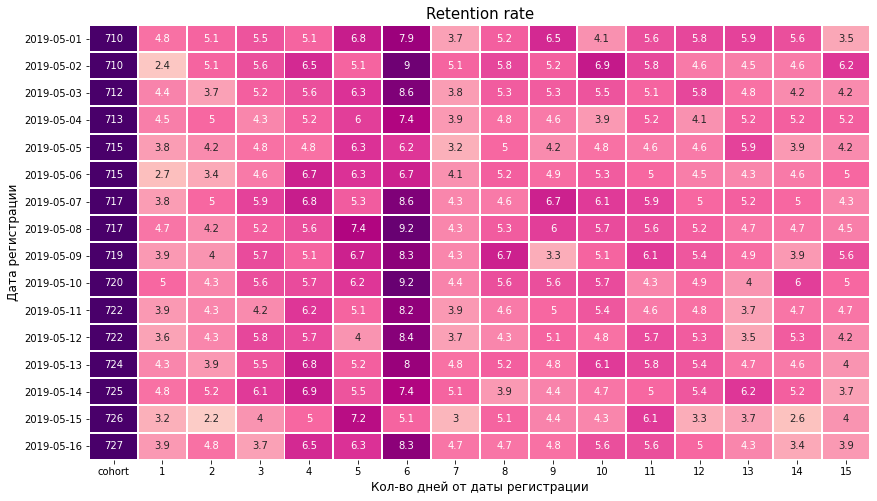

In [22]:
retention(path_reg, path_log)

Наблюдается низкий RR первого дня (1-2%) авторизаций пользователей. Возможно это связано с процессом регистрации, авторизации или оплаты пользователями. Потом наблюдается увеличение RR на протяжении первых 10-12 дней (среднее время удержания в игре) со дня регистрации до 7-8% и плавный спад к концу месяца. Рекомендуется провести анализ причин низкого RR в первые дни после регистрации.

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [106]:
# data A/B test
path_ab = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-g-zhukov/Проект_1_Задание_2.csv'
df = pd.read_csv(path_ab, sep=';')

In [81]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


 Смотрим на типы данных, пропущенные значения

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [83]:
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

 Посмотрим показатели revenue в каждой из групп.

In [84]:
df[df.testgroup == 'a'].revenue.describe().round()

count    202103.0
mean         25.0
std         921.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       37433.0
Name: revenue, dtype: float64

In [85]:
df[df.testgroup == 'b'].revenue.describe().round()

count    202667.0
mean         27.0
std         287.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max        4000.0
Name: revenue, dtype: float64

Видим очень сильные различия в максимальном ревенью, а также сильную разницу в средне-квадратичном отклонении.


Проверка утверждения о том, что ARPU в тестовой группе выше на 5%, чем в контрольной

In [86]:
# split the data into two more tables: the data of the control group and the data of the test group
a_group = df.query("testgroup == 'a'")
b_group = df.query("testgroup == 'b'")

In [87]:
ARPU_test = ((b_group.revenue.sum() - a_group.revenue.sum()) / a_group.revenue.sum()) * 100
ARPU_test.round(2)

5.56

Построим график по платящим пользователям, чтобы лучше понимать ситуацию.

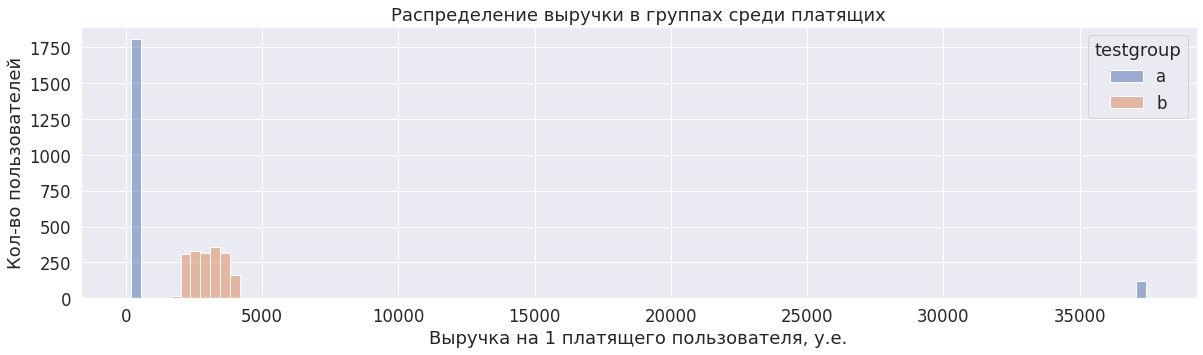

In [88]:
plt.figure(figsize=(20, 5))
sns.set(font_scale=1.5)
z = sns.histplot(x='revenue', data=df.query('revenue > 0'), hue='testgroup')
z.set_xlabel("Выручка на 1 платящего пользователя, у.е.")
z.set_ylabel("Кол-во пользователей")
z.set(title="Распределение выручки в группах среди платящих")
plt.show()

In [89]:
# divide the dataset into a control one for convenience
control = df.query('testgroup == "a" and revenue > 0')

In [90]:
control.query('revenue>35000')['user_id'].count()

123

In [91]:
100 * (control.query('revenue>35000')['revenue'].count() / control['user_id'].count()).round(2)

6.0

In [92]:
100 * (control.query('revenue>35000')['revenue'].sum() / control.revenue.sum()).round(2)

89.0

 По гистограмме видно, что тестовая и контрольная группы сильно отличаются. В контрольной группе выручка распределена неравномерно
- основная часть пользователей приносят выручку от 200 до 400 у.е.
- небольшая группа приносит выручку свыше 35000 у.е. (123 человека (6%) дают 89% выручки)

В тестовой группе платежи распределены более равномерно
- сумма платежей в несколько раз превышает значения небольших платежей в контрольной группе и в несколько раз ниже крупных платежей контрольной группы.

Наблюдается явный перекос и неравномерность в значениях Revenue по двум группам.

**Первым вопросом к заданию был вопрос о том, какой набор предложений по результатам тестирования можно считать лучшим?**
Судя по уже полученным данным можно с большой уверенностью сказать, что репрезентатичность выборок была нарушена, поэтому группы необходимо пересобрать. 

**Вторым вопросом был вопрос о том, какие метрики стоит проанализировать для принятия правильного решения и как?**
Видно, что огромная доля пользователей не платит, поэтому стоит отдельно рассмотреть только платящих. Значит помимо метрики ARPU нужно рассчитать метрику ARPPU. Также мы можем рассчитать Conversion Rate и посмотреть, какая доля из общего числа пользователей совершает целевое действие (платит).



Если мы уверены, что распределили пользователей корректно, то тогда имеет смысл оценить статистически значимы различия в группах или нет. По гистограммам видно, что распредления являются не нормальными. Выборки большого размера, поэтому можем использовать Т-тест. Для начала посмотрим различия во всех основных показателях и определимся, по какому показателю будем оценивать различия.

Посмотрим на данные по выручке, arpu, arppu и conversion rate в каждой группе

In [93]:
# form a dataset with all users, add information about paying users
paying = df.query('revenue>0').groupby('testgroup', as_index=False).agg({'user_id': 'nunique'}) \
    .rename(columns={'user_id': 'paying_users'})

In [94]:
# form a dataset with all users, add information about paying users
df1 = df.groupby('testgroup', as_index=False).agg({'user_id': 'nunique', 'revenue': 'sum'})\
    .merge(paying, how='left', on='testgroup').rename(columns={'user_id': 'users'})

In [95]:
# calculate the arpu, arppu and conversion rate (CR) indicators
df1['arpu'] = (df1['revenue'] / df1['users']).round(2)
df1['arppu'] = (df1['revenue'] / df1['paying_users']).round(2)
df1['CR'] = (100 * (df1['paying_users'] / df1['users'])).round(3)
df1

,testgroup,users,revenue,paying_users,arpu,arppu,CR
0,a,202103,5136189,1928,25.41,2664.00,0.954
1,b,202667,5421603,1805,26.75,3003.66,0.891


Видно, что в контрольной группе показатели arpu и arppu ниже, чем в тестовой, однако конверсия в покупку (CR) выше у контрольной группы. Используем Т-тест для revenue.
- Н0 - различий у групп нет
- Н1 - группы значимо различаются. 

In [96]:
# assessment by revenue
pg.ttest(x=df[df.testgroup == 'a'].revenue,
         y=df[df.testgroup == 'b'].revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.623488,240991.130782,two-sided,0.532965,"[-5.54, 2.87]",0.001962,0.004,0.095694


Значение p-value > 0,05, следовательно, принимаем нулевую гипотезу, что различий в группах нет.

 Конверсия является бинарной.
В нашем эксперименте 2 независимые группы (тест/контроль).
Для данных условий лучше всего подходит статистический тест Хи-квадрат Пирсона.
- H0: конверсия в тестовой и контрольной группах не различается 
- H1: конверсия в тестовой и контрольной группах различается

Для определения статистическо значимых различий в конверсии между группами, воспользуемся таблицей сопряженности Гипотезы:

In [97]:
df1.set_index('testgroup')[['users', 'paying_users']]

,users,paying_users
testgroup,,
a,202103,1928
b,202667,1805


In [98]:
df['paying'] = df['revenue'].apply(lambda x: 'yes' if x > 0 else 'no')

In [99]:
table = pd.crosstab(df.paying, df.testgroup)
table

testgroup,a,b
paying,,
no,200175,200862
yes,1928,1805


In [100]:
# Pearson's Chi-square test
stat, p, dof, expected = stats.chi2_contingency(table)
p

0.03647561892312613

p-value < 0.05 следовательно нулевая гипотеза отвергается, поэтому мы можем сказать, что различие в конверсии в покупку между контрольной и тестовой группой является статистически значимым

Проверим возможность использования T-критерия Стьюдента, а также проверим с помощью критерия Левена гомогенность дисперсий внутри групп.

Критерий Левена
- H0 - Дисперсии внутри тестовой и контрольной группы примерно равны (p-value > 0.05)
- H1 - Дисперсии внутри тестовой и контрольной группы различаются (p-value < 0.05)

In [101]:
ss.levene(a_group.revenue, b_group.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

 p > 0,05 отколнить нулевую гипотезу нельзя. Требование гомогенности дисперсий соблюдается, возможно использование Т-критерия Стьюдента.

#### ARPPU
- Н0 - разница в значениях revenue между тестовой и контрольной отсутствует (если р-уровень значимости больше 0.05)
- Н1 - разница в значениях revenue существует (р-уровень значимости меньше 0.05)

In [102]:
# t-test
ss.ttest_ind(a_group.revenue, b_group.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

pvalue > 0.05 - принимаем нулевую гипотезу, т.е. в наших группах нет статистически значимых различий

Чтобы смоделировать среднее в ГС можно воспользоваться методом бутстрап, который из имеющейся выборки берет множество подвыборок и сравнивает их средние значения. Чем больше подвыборок мы сделаем, тем ближе будет среднее всех выборочных средних к среднему в реальной ГС. Сравним средние в группе А с выбросами и средние в этой же группе, но без выбросов, методом бутстрап:
- H0 – в генеральной совокупности никакого различия между средней выручкой нет 
- H1 – средние по выручке в генеральной совокупности не равны (альтернативная гипотеза)
- Порог значимости - 0,05 (если в результате теста мы получим p-value больше 0,05, то различий между средними в группах нет и выбросы не оказывают статистически значимого влияния на среднее).

In [111]:
def get_bootstrap( 
        
    data,  # dataframe with data by groups 
    boot_it,  # number of bootstrap subsamples 
    bootstrap_conf_level,  # significance level
    metrica=''  # analyzed metric, default metrica = CR
):
    boot_data = []
    boot_len = max([len(data.query("testgroup == 'a'")), len(data.query("testgroup == 'b'"))])
    for i in tqdm(range(boot_it)):  # extracting a subsample
        samples = data.sample(boot_len, replace=True)  # return parameter
        if metrica == 'CR' or metrica == '':
            CR_1 = samples.query("testgroup == 'a'").agg({'user_id': 'count'}).user_id\
                / samples.query("testgroup == 'a' and revenue != 0").agg({'user_id': 'count'}).user_id
            CR_2 = samples.query("testgroup == 'b'").agg({'user_id': 'count'}).user_id\
                / samples.query("testgroup == 'b' and revenue != 0").agg({'user_id': 'count'}).user_id
            boot_data.append(CR_1 - CR_2)
        elif metrica == 'ARPU':
            ARPU_1 = samples.query("testgroup == 'a'").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'a'").agg({'user_id': 'count'}).user_id
            ARPU_2 = samples.query("testgroup == 'b'").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'b'").agg({'user_id': 'count'}).user_id
            boot_data.append(ARPU_1 - ARPU_2)
        elif metrica == 'ARPPU':
            ARPPU_1 = samples.query("testgroup == 'a' and revenue != 0").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'a' and revenue != 0").agg({'user_id': 'count'}).user_id
            ARPPU_2 = samples.query("testgroup == 'b' and revenue != 0").agg({'revenue': 'sum'}).revenue\
                / samples.query("testgroup == 'b' and revenue != 0").agg({'user_id': 'count'}).user_id
            boot_data.append(ARPPU_1 - ARPPU_2)
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    # confidence intervals    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    
    # p-value
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('Разница бутстрапированных средних значений')
    plt.ylabel('Количество')
    plt.title("Распределение бутстрапированных средних значений")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

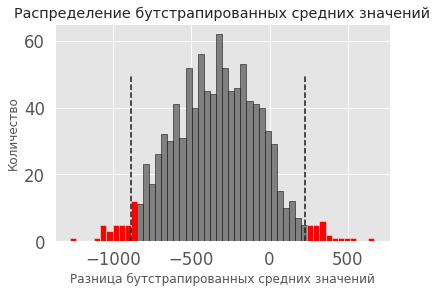

In [112]:
booted_data = get_bootstrap(df, 1000, 0.95, 'ARPPU')

In [37]:
booted_data["p_value"]

0.27800148188121443

'0' лежит в границах доверительного интервала, значит по итогам этого теста у нас нет оснований отклонить нулевую гипотезу.
Если посмотреть на p-value, то он значительно больше 0,05, что также подтверждает верность нулевой гипотезы

 p-value < 0.05 следовательно нулевая гипотеза отвергается, поэтому мы можем сказать, что различие в конверсии в покупку между контрольной и тестовой группой является статистически значимым

### Выводы

- По результатам проведенного А/В тестирования проанализированы метрики конверсии в покупку (CR), средний доход на одного пользователя (ARPU) и средний доход на одного платящего пользователя (ARPPU), написана функция проверки гипотез методом bootstrap.

- На основании проведенных исследований мы выяснили, что показатели ARPU и ARPPU оказались выше в тестовой группе, однако данное различие оказалось статистически незначимо. В то же время конверсия в покупку CR оказалась выше в контрольной группе, при этом различие казалось статически значимым.

- На основании выводов о CR можно сказать, что набор акций неблагоприятно сказался на конверсии в покупку у тестовой группы, где количество платящих пользователей стало ниже, а размер тестовой группы оказался выше, чем в контрольной. При этом данный показатель игнорирует размер выручки, который в тестовой группе оказался выше.

- По результатам A/B теста в датасете выявлены 3 категории пользователей: 
  1. платят немного (в диапазоне 200-400)
  2. платят очень много (>35000, топовые клиенты), обе эти категории пользователей попали в контрольную группу, в тестовой группе их нет.
  3. платят в диапазоне 2000-4000, попали только в тестовую группу.

Из-за слишком большого разброса наших пользователей по значению revenue в группах, делаю вывод, что репрезентативность выборок нарушена. Имеющиеся выборки неправильно сформированы, между контрольной и тестовой группами нечестно распределены пользователи по размеру revenue.

Покупательная способность пользователей в выборках различна, значит обе группы не соответствуют генеральной совокупности всех пользователей.

Исходя из результатов нельзя сделать однозначный вывод о том, что набор акционных предложений оказался лучше или хуже в определенной группе. *Если же рассматривать вариант, что предоставленные данные корректные, то я бы предложил использовать тестовое акционное предложение, потому что в данном случае поведение пользователей можно назвать более предсказуемым (нормальное распределение и выше средний кейс покупки), но при этом заняться исследованием "выброса" в А-группе, которые дали огромный прирост (89% генерируется 6% пользоваталей) выручки.*

**Если смотреть по фактам: считаю, что результаты A/B теста неудачные, и какие-то дальнейшие сравнения двух групп бессмысленны. Рекомендую пересобрать группы и провести тестирование заново.**

После этого нужно будет пересчитать и проанализировать метрики ARPU, ARPPU и CR. И если мы получим статзначимые различия, то тогда сможем принять решение, какой же набор предложений можно считать лучшим.

## Задание 3

 В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?
 
 По условиям, тематические события дают ряд преимуществ или бонусов для игроков, которые в них участвуют, следовательно, такие события могут сопровождаться ростом числа игроков, вовлеченности, увеличением длины сессии  и, возможно, приведут к росту выручки.
 
 ##### Показатели, которые позволят отследить рост числа игроков:

- Средний DAU/MAU (или stickiness ratio) - покажет частоту, с которой пользователь взаимодействует с приложением

- DAU/WAU/MAU - покажут число активных юзеров за период

- отношение числа новых пользователей за какой-то промежуток времени ко всем пользователям за этот же промежуток времени


##### Показатели, которые позволят отследить кол-во сессий и их продолжительность
 
- средняя длина сессии (ASD)

- количество сессий (NoS)

##### Показатели, которые позволят отследить увеличение вовлеченности и выручки

- ARPU/ARPPU - средняя выручка на юзера/платящего юзера
- Retenion Rate - коэффициент удержания клиентов
- Средний чек - размер среднего чека

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?
 
 
- Усложнение механики потенциально может вызвать отток клиентов, в этом случае необходимо дополнительно отслеживать показатель Retenion Rate. Если он постоянно падает, то, возможно, в игре есть какие-то проблемы (баги) и их нужно устранить максимально быстро.
- Среднее количество попыток, затраченных на прохождение каждого уровня, а также среднее количество уровней, на которое были отброшены игроки - это даст представление о том, насколько сложными оказались уровни с новой механикой для игроков.
- Также целесообразно построить воронку конверсии и посмотреть конкретно из какого уровня в следующий конверсия самая низкая. В идеале это должна быть равномерная воронка конверсии. Если процент конверсии где-то аномально низкий, то такие уровни необходимо перебалансировать.